## U-Net Model Evaluation for Kidney Glomeruli Segmentation

This Python script is designed to evaluate a pre-trained U-Net model on a dataset of kidney tissue images for semantic segmentation of glomeruli. The process includes:
1.  Setting up configurations, including paths to data and the model.
2.  Defining the U-Net model architecture.
3.  Creating a custom dataset loader for test images and masks.
4.  Loading the trained U-Net model weights.
5.  Calculating segmentation performance metrics (IoU and Dice coefficient).
6.  Visualizing the model's predictions against ground truth masks.


### Cell 1: Configuration and Setup
* Imports libraries and sets up main paths for the dataset, model, and output.
* Configures image size and the device (GPU or CPU) for computation.

In [31]:
import os
import sys
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import colorsys # For random colors
from pathlib import Path

# --- Configuration ---
# Get the directory of the current notebook, then go one level up for the ROOT_DIR
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__")) # This works if running as a script, for notebooks use os.getcwd() if CWD is 'evaluation'
                                                            # or manually set if structure is fixed.
                                                            # If your Jupyter kernel starts in 'evaluation', os.getcwd() is '.../evaluation'
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..')) # Assumes CWD is 'evaluation'
# If you are sure the notebook is in 'evaluation' and kernel starts there:
# ROOT_DIR = '..'

DATASET_DIR = os.path.join(ROOT_DIR, 'datasets')
TEST_IMG_DIR = os.path.join(DATASET_DIR, 'test', 'images')
TEST_MASK_DIR = os.path.join(DATASET_DIR, 'test', 'masks')

# Path to your trained U-Net model
MODEL_PATH = os.path.join(ROOT_DIR, 'outputs_models', 'unet_model_ep2.pth')

specific_gpu_index = 1
if torch.cuda.is_available() and torch.cuda.device_count() > specific_gpu_index:
    DEVICE = torch.device(f'cuda:{specific_gpu_index}')
elif torch.cuda.is_available():
    print(f"Warning: GPU {specific_gpu_index} not available, falling back to cuda:0.")
    DEVICE = torch.device('cuda:0') # Fallback to GPU 0 if specified one isn't there but CUDA is
else:
    DEVICE = torch.device('cpu')

IMG_SIZE = 256
NUM_CLASSES_UNET = 1

print(f"Using device: {DEVICE}")
print(f"Test image directory: {TEST_IMG_DIR}")
print(f"Test mask directory: {TEST_MASK_DIR}")
print(f"U-Net Model path: {MODEL_PATH}")
print(f"Image size for U-Net: {IMG_SIZE}")

Using device: cuda:1
Test image directory: /users/nfs/Etu7/21410437/glomeruli_segmentation/datasets/test/images
Test mask directory: /users/nfs/Etu7/21410437/glomeruli_segmentation/datasets/test/masks
U-Net Model path: /users/nfs/Etu7/21410437/glomeruli_segmentation/outputs_models/unet_model_ep2.pth
Image size for U-Net: 256


### Cell 2: U-Net Model Definition
* Defines the `UNet` class, detailing the neural network's architecture.
* This includes encoder (down-sampling path), bottleneck, and decoder (up-sampling path) with skip connections.


In [32]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        def conv_block(ic, oc):
            return nn.Sequential(
                nn.Conv2d(ic, oc, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(oc, oc, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.enc5 = conv_block(512, 1024) # Bottleneck in some architectures, or deeper encoder
        self.pool5 = nn.MaxPool2d(2) # Added based on your training code structure
        
        self.drop = nn.Dropout2d(0.5) # Added based on your training code structure
        self.bottleneck = conv_block(1024, 2048) # True bottleneck based on your training code

        self.up5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec5 = conv_block(2048, 1024) # Concatenates 1024 (from up5) + 1024 (from e5)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512) # Concatenates 512 (from up4) + 512 (from e4)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)  # Concatenates 256 (from up3) + 256 (from e3)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)  # Concatenates 128 (from up2) + 128 (from e2)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)   # Concatenates 64 (from up1) + 64 (from e1)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        e5 = self.enc5(self.pool4(e4))
        
        b = self.drop(self.bottleneck(self.pool5(e5)))
        
        d5 = self.dec5(torch.cat([self.up5(b), e5], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d5), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.final(d1)

print("U-Net model class defined.")

U-Net model class defined.


### Cell 3: Dataset Class and Transformations
* Defines `UNetKidneyDataset` to load test images and their corresponding masks.
* Specifies image transformations (resize, normalize, convert to tensor) using `albumentations`.


In [33]:
class UNetKidneyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, file_list=None, img_size=256): # Added img_size
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size # Store img_size
        if file_list:
             self.image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        else:
            self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask.unsqueeze(0) if mask.ndim == 2 else mask

        # Return img_name instead of the loaded PIL image
        return image, mask, img_name # Removed original_image_pil

def get_unet_test_transform(img_size):
    # These should match the validation transforms used during U-Net training
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Example, use your training's normalization
        ToTensorV2(), # Converts image and mask to PyTorch tensors
    ])

print("Dataset class and test transformations defined.")

Dataset class and test transformations defined.


### Cell 4: Model Loading
* Creates an instance of the U-Net model.
* Loads the saved weights of your trained U-Net model.
* Switches the model to evaluation mode (`eval()`).


In [34]:
# Instantiate the U-Net model
unet_model = UNet(in_channels=3, out_channels=NUM_CLASSES_UNET).to(DEVICE)

# Load trained weights
try:
    unet_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Successfully loaded U-Net model weights from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading U-Net model weights: {e}")
    print("Ensure the model architecture matches the saved weights and the path is correct.")
    # Handle error appropriately, e.g., by exiting or allowing to proceed with an untrained model for debugging structure

unet_model.eval() # Set model to evaluation mode
print("U-Net model loaded and set to evaluation mode.")

/tmp/ipykernel_2103544/1880569624.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Successfully loaded U-Net model weights from /users/nfs/Etu7/21410437/glomeruli_segmentation/outputs_models/unet_model_ep2.pth
U-Net model loaded and set to evaluation mode.


### Cell 5: Metric Calculation Functions
* Defines the `calculate_semantic_iou_dice` function.
* This function computes the Intersection over Union (IoU) and Dice coefficient for comparing predicted masks to ground truth masks.


In [35]:
def calculate_semantic_iou_dice(gt_mask_np, pred_mask_np, smooth=1e-7):
    """
    Calculates semantic IoU and Dice coefficient for binary masks.
    Assumes gt_mask_np and pred_mask_np are 2D numpy arrays (H, W) with binary values (0 or 1).
    """
    if gt_mask_np.shape != pred_mask_np.shape:
        raise ValueError(f"Shape mismatch: GT mask shape {gt_mask_np.shape} vs Pred mask shape {pred_mask_np.shape}")

    intersection = np.logical_and(gt_mask_np, pred_mask_np).sum()
    union = np.logical_or(gt_mask_np, pred_mask_np).sum()
    
    iou = (intersection + smooth) / (union + smooth)
    
    dice = (2. * intersection + smooth) / (gt_mask_np.sum() + pred_mask_np.sum() + smooth)
    
    # Handle cases where both masks are empty
    if gt_mask_np.sum() == 0 and pred_mask_np.sum() == 0:
        iou = 1.0
        dice = 1.0
        
    return iou, dice

print("Metric calculation functions defined.")

Metric calculation functions defined.


### Cell 6: Visualization Utilities
* Defines `apply_mask_overlay_pil` to draw a colored, semi-transparent mask on an image.
* Defines `visualize_unet_output` to display the ground truth and predicted masks side-by-side (using the light purple overlay as recently updated).


In [36]:
# Definition of apply_mask_overlay_pil (should be the same as your Cell 6)
def apply_mask_overlay_pil(image_pil, mask_np, color_rgb_float, alpha=0.5):
    """
    Applies a semi-transparent colored mask overlay to a PIL image.
    image_pil: Input PIL Image.
    mask_np: Binary numpy array mask (H, W), 0 or 1.
    color_rgb_float: Tuple of (R, G, B) float values for the mask color (0-1 range).
    alpha: Transparency of the mask.
    Returns: PIL Image with overlay.
    """
    if mask_np.ndim == 3 and mask_np.shape[0] == 1: # Handle [1, H, W]
        mask_np = mask_np.squeeze(0)
    elif mask_np.ndim != 2:
        raise ValueError(f"Mask must be 2D (H,W) or 3D (1,H,W), got {mask_np.shape}")

    image_np_uint8 = np.array(image_pil.convert("RGB"))
    color_rgb_uint8 = (np.array(color_rgb_float) * 255).astype(np.uint8)
    
    overlay_np = np.zeros_like(image_np_uint8)
    for c_idx in range(3): # Iterate over R, G, B channels
        overlay_np[mask_np == 1, c_idx] = color_rgb_uint8[c_idx]

    blended_np = image_np_uint8.copy()
    foreground_pixels = (mask_np == 1)
    
    for c_idx in range(3):
        channel_blended = image_np_uint8[foreground_pixels, c_idx] * (1 - alpha) + overlay_np[foreground_pixels, c_idx] * alpha
        blended_np[foreground_pixels, c_idx] = channel_blended.astype(np.uint8)
            
    return Image.fromarray(blended_np)

# MODIFIED visualize_unet_output function
def visualize_unet_output(original_pil_for_overlay, gt_mask_np, pred_mask_np, img_name, iou=-1, dice=-1):
    """
    Visualizes the ground truth mask overlay and predicted mask overlay for U-Net
    using a transparent light purple color.
    The original image itself is not plotted separately but used for overlays.
    """
    if gt_mask_np.ndim == 3: gt_mask_np = gt_mask_np.squeeze(0) # Ensure 2D
    if pred_mask_np.ndim == 3: pred_mask_np = pred_mask_np.squeeze(0) # Ensure 2D

    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Shows GT and Prediction

    # Define the transparent light purple color
    light_purple_color = (0.9, 0.2, 0.2, 0.8) # R, G, B - Adjust to your preference
    mask_alpha = 0.5 # Transparency level

    # Plot Ground Truth Mask Overlay with light purple
    gt_overlay_pil = apply_mask_overlay_pil(original_pil_for_overlay, gt_mask_np, 
                                            color_rgb_float=light_purple_color, alpha=mask_alpha)
    axes[0].imshow(gt_overlay_pil)
    axes[0].set_title(f"Ground Truth Mask: {img_name}")
    axes[0].axis('off')

    # Plot Predicted Mask Overlay with the same light purple
    # (or define a slightly different shade if you want to distinguish them by color too)
    # e.g., slightly_darker_purple = (0.7, 0.55, 0.8)
    pred_overlay_pil = apply_mask_overlay_pil(original_pil_for_overlay, pred_mask_np, 
                                              color_rgb_float=light_purple_color, alpha=mask_alpha)
    axes[1].imshow(pred_overlay_pil)
    title_pred = "Predicted Mask"
    if iou != -1 and dice != -1:
        title_pred += f"\nIoU: {iou:.4f}, Dice: {dice:.4f}"
    axes[1].set_title(title_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("U-Net visualization utilities updated with new colors.")

U-Net visualization utilities updated with new colors.


### Cell 7: Evaluation Loop
* Prepares the test dataset and DataLoader.
* Loops through all test images:
    * Gets model predictions for each image.
    * Calculates IoU and Dice scores by comparing predictions with ground truth masks.
    * Stores these scores for all images.

In [37]:
# Create test dataset and dataloader
test_transform = get_unet_test_transform(IMG_SIZE)
test_image_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

# Limiting to 200 test images as per the output example, if more exist.
# If you want to evaluate on all, remove this line or adjust the number.
# test_image_files = test_image_files[:200] 

test_dataset = UNetKidneyDataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transform=test_transform, file_list=test_image_files, img_size=IMG_SIZE) # Added img_size
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

print(f"Number of test images to evaluate: {len(test_dataset)}")

all_semantic_ious = []
all_semantic_dices = []
processed_image_paths = [] # To keep track of images for which metrics are calculated

with torch.no_grad():
    # MODIFIED: Removed original_pil_list from unpacking
    for i, (image_tensor, gt_mask_tensor, img_name_list) in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Evaluating U-Net on Test Set"):
        image_tensor = image_tensor.to(DEVICE)
        gt_mask_tensor = gt_mask_tensor.to(DEVICE)

        pred_logits = unet_model(image_tensor)
        pred_probs = torch.sigmoid(pred_logits)
        pred_binary_mask_tensor = (pred_probs > 0.5).float()

        for j in range(image_tensor.shape[0]): # Iterate through batch
            gt_mask_np = gt_mask_tensor[j].squeeze().cpu().numpy().astype(np.uint8)
            pred_mask_np = pred_binary_mask_tensor[j].squeeze().cpu().numpy().astype(np.uint8)
            
            img_name = img_name_list[j] # This is now a string (image name)
            processed_image_paths.append(img_name)

            iou, dice = calculate_semantic_iou_dice(gt_mask_np, pred_mask_np)
            all_semantic_ious.append(iou)
            all_semantic_dices.append(dice)

            # If you want to visualize inside this loop (example):
            # if i < 1: # Visualize first image of the first batch
            #    # Load original PIL image for visualization here
            #    original_img_full_path = os.path.join(TEST_IMG_DIR, img_name) # TEST_IMG_DIR from Cell 1
            #    original_pil_for_viz = Image.open(original_img_full_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE)) # IMG_SIZE from Cell 1
            #    visualize_unet_output(original_pil_for_viz, gt_mask_np, pred_mask_np, img_name, iou, dice)
# ... (rest of Cell 7) ...

print(f"Evaluation completed for {len(all_semantic_ious)} images.")
if len(all_semantic_ious) != len(test_dataset):
    print(f"Warning: Number of evaluated images ({len(all_semantic_ious)}) does not match dataset size ({len(test_dataset)}).")

Number of test images to evaluate: 200


Evaluating U-Net on Test Set:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating U-Net on Test Set: 100%|██████████| 200/200 [00:03<00:00, 56.58it/s]

Evaluation completed for 200 images.


### Cell 8: Calculate and Display Average Metrics
* Computes the average IoU and Dice scores from all the test images evaluated in Cell 7.
* Prints these mean performance metrics.


In [38]:
# Calculate and print average metrics
if all_semantic_ious:
    mean_iou = np.mean(all_semantic_ious)
    print(f"Mean Semantic IoU over {len(all_semantic_ious)} test images: {mean_iou:.4f}")
else:
    mean_iou = float('nan')
    print("Mean Semantic IoU: N/A (no images evaluated or list is empty)")

if all_semantic_dices:
    mean_dice = np.mean(all_semantic_dices)
    print(f"Mean Semantic Dice over {len(all_semantic_dices)} test images: {mean_dice:.4f}")
else:
    mean_dice = float('nan')
    print("Mean Semantic Dice: N/A (no images evaluated or list is empty)")

# Compare with your expected output:
# Your output shows: Mean IoU : 0.718, Mean Dice: 0.528 for MaskRCNN.
# This script will compute these for U-Net.
print("\n*** U-Net Evaluation Summary ***")
print(f"Mean IoU : {mean_iou:.3f}") # Matching your output format
print(f"Mean Dice: {mean_dice:.3f}") # Matching your output format

Mean Semantic IoU over 200 test images: 0.7959
Mean Semantic Dice over 200 test images: 0.8504

*** U-Net Evaluation Summary ***
Mean IoU : 0.796
Mean Dice: 0.850


### Cell 9 (This was the second "Cell 8" in your script, for detailed visualization): Visualize Individual Predictions
* Defines helper functions to visualize predictions for specific images:
    * `display_single_unet_prediction`: Shows GT and predicted masks for one image.
    * `visualize_unet_image_by_filename`: Shows results for an image specified by its filename.
    * `visualize_specific_unet_image_by_index`: Shows results for an image at a given dataset index.
    * `visualize_random_unet_images`: Shows results for a few randomly chosen images.
* Includes example calls to these functions to inspect model performance visually.



--- Visualizing SPECIFIC U-Net prediction for image file: 2f6ecfcdf_0667.png ---
Visualizing U-Net prediction for: 2f6ecfcdf_0667.png (Index: 56)


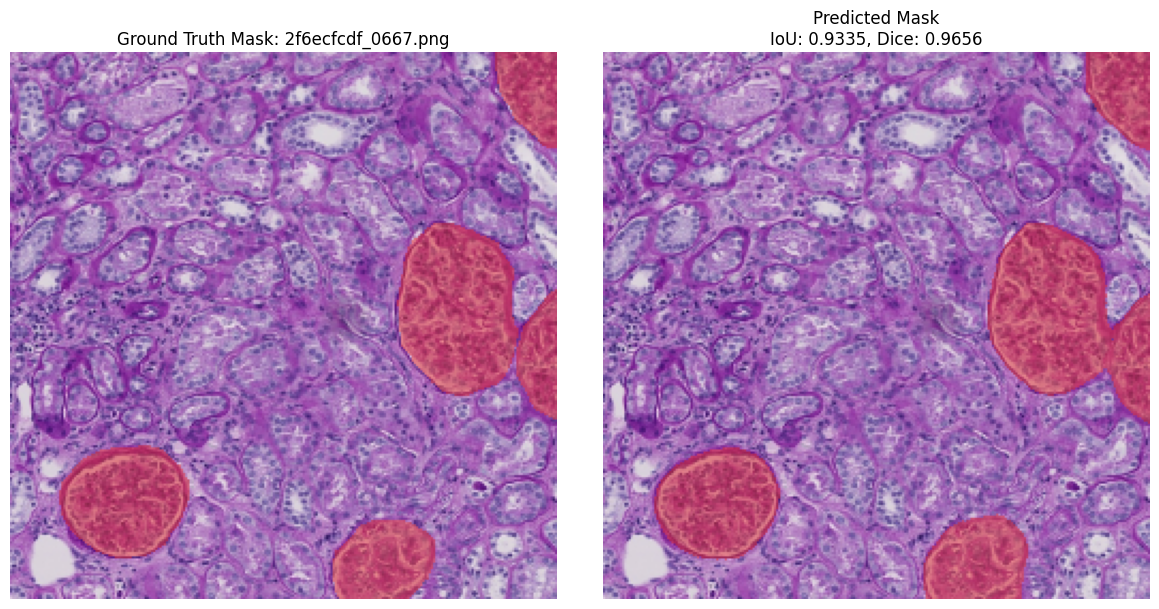


--- Visualizing 5 RANDOM U-Net test predictions ---
Visualizing U-Net prediction for: 4ef6695ce_1370.png (Index: 76)


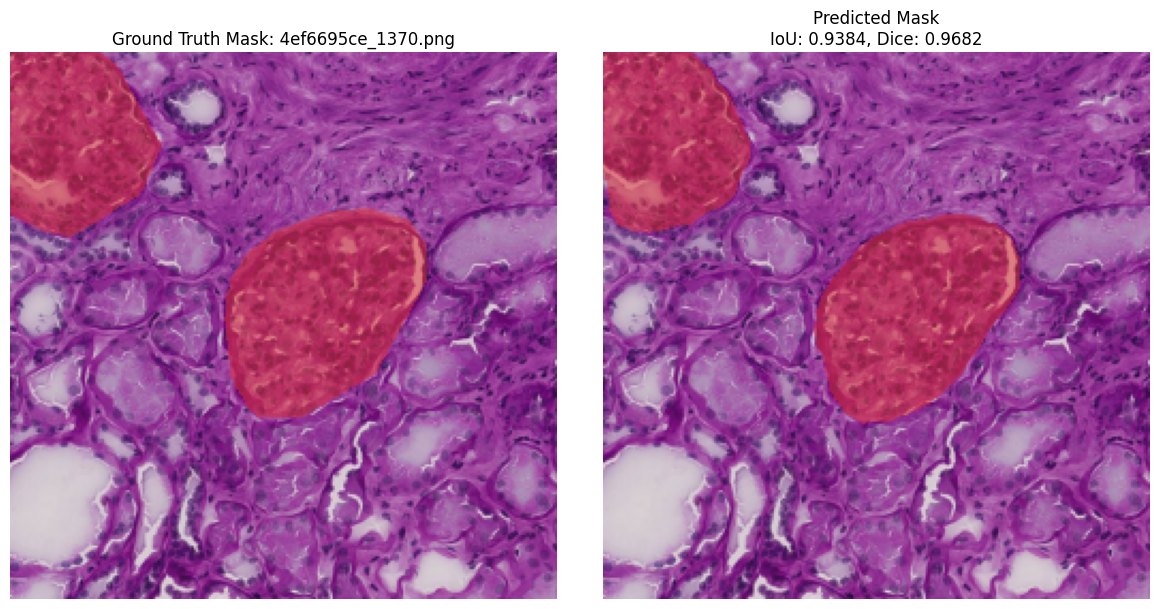

Visualizing U-Net prediction for: 4ef6695ce_1260.png (Index: 73)


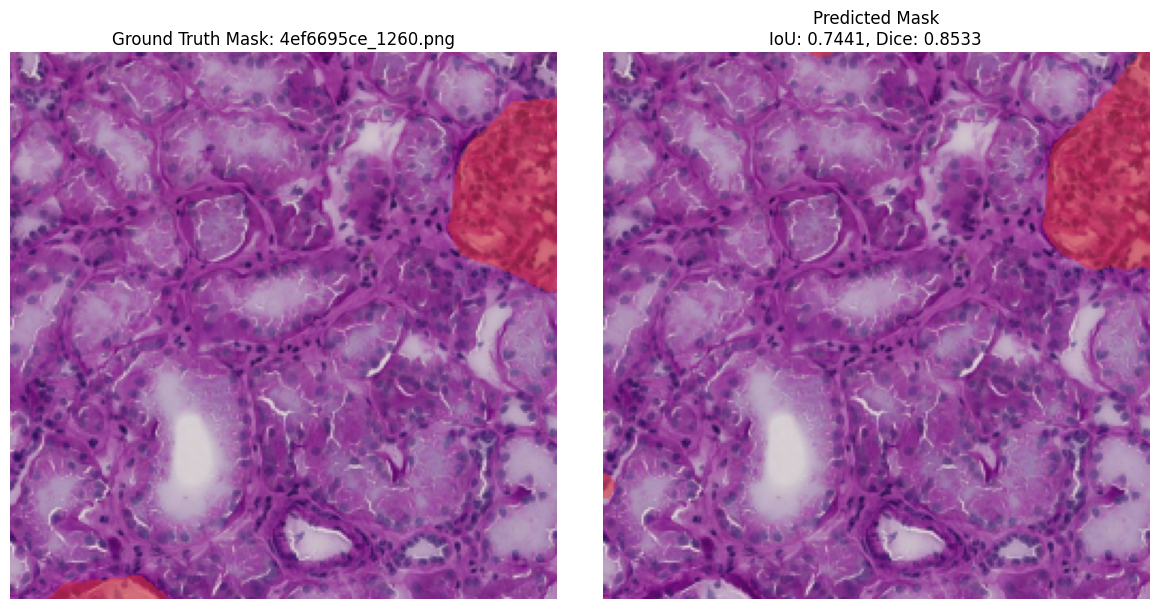

Visualizing U-Net prediction for: 4ef6695ce_1426.png (Index: 79)


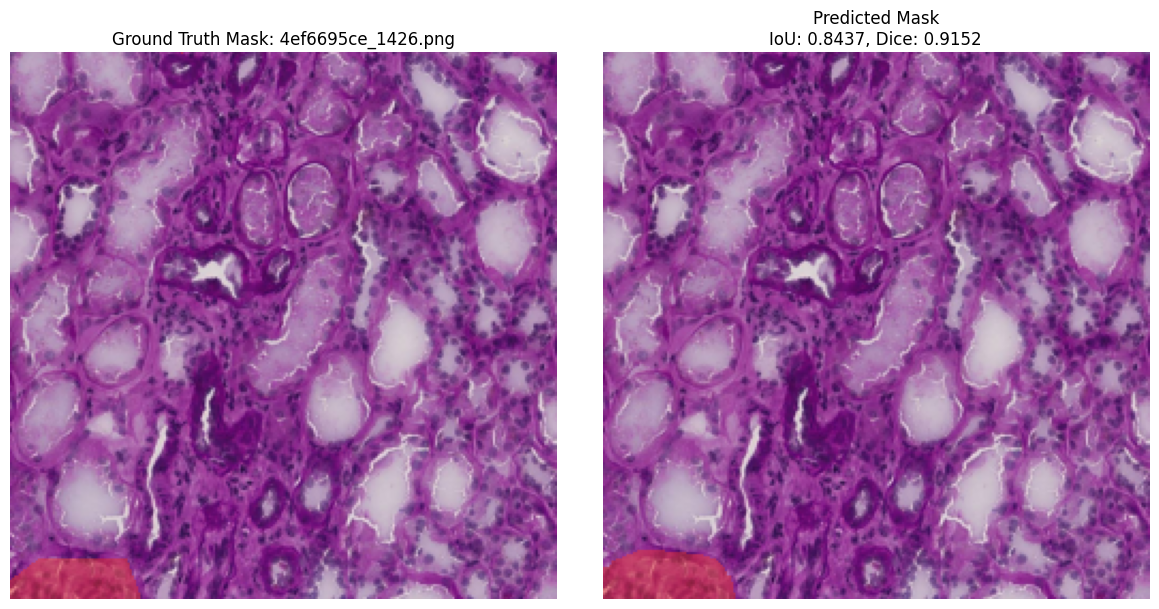

Visualizing U-Net prediction for: 8242609fa_0645.png (Index: 110)


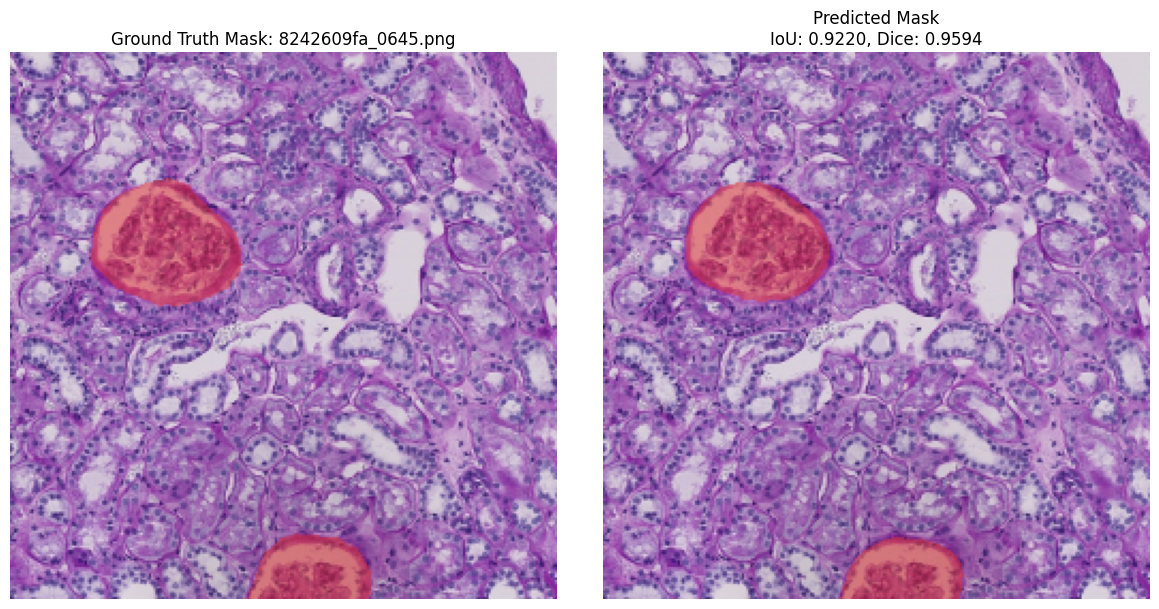

Visualizing U-Net prediction for: 1e2425f28_0432.png (Index: 34)


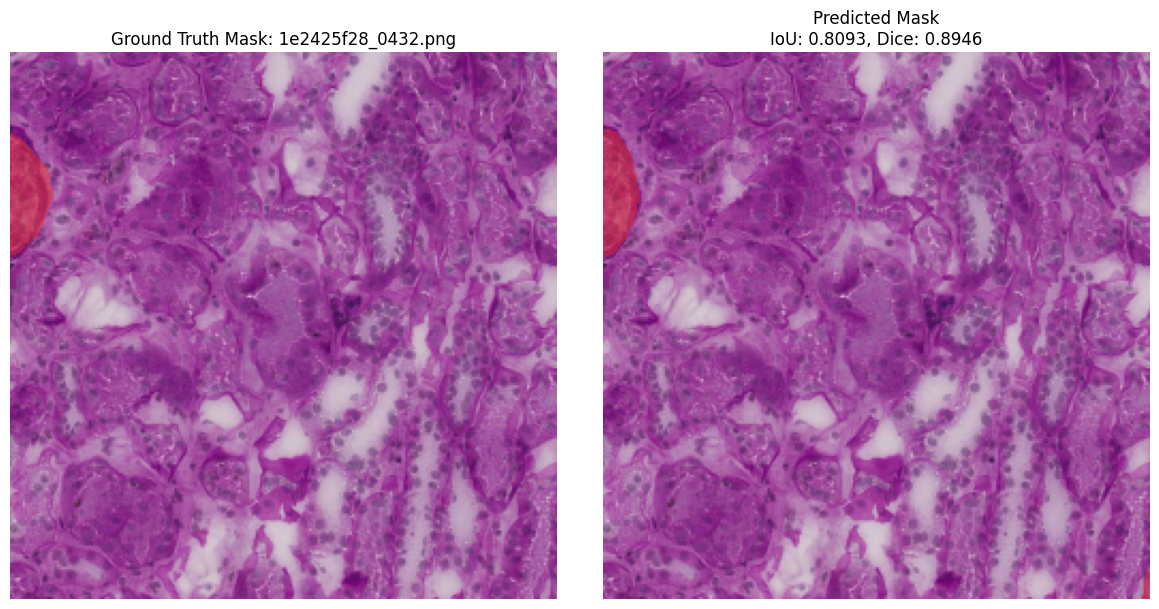

In [39]:
def display_single_unet_prediction(idx_to_show, dataset, model, device):
    """
    Loads an image and its ground truth by index, runs U-Net inference,
    calculates metrics for this single image, and visualizes the output.
    The visualization will show GT and Predicted mask overlays.
    
    Args:
        idx_to_show (int): Index of the image in the dataset.
        dataset (Dataset): The UNetKidneyDataset instance (e.g., test_dataset).
        model (torch.nn.Module): The trained U-Net model in eval mode.
        device (torch.device): The device to run inference on.
    """
    if not (0 <= idx_to_show < len(dataset)):
        print(f"Error: Index {idx_to_show} is out of bounds for dataset with length {len(dataset)}.")
        return

    # Get processed image tensor, ground truth mask tensor, and image name from dataset
    # dataset.__getitem__ should return: image_tensor, gt_mask_tensor, img_name
    image_tensor, gt_mask_tensor, img_name_from_dataset = dataset[idx_to_show]
    
    # Load the original PIL image using img_name for visualization overlays
    # TEST_IMG_DIR and IMG_SIZE are expected to be globally defined (e.g., in Cell 1)
    try:
        # Use img_name_from_dataset which is guaranteed to be correct for the loaded tensors
        original_pil_path = os.path.join(TEST_IMG_DIR, img_name_from_dataset) # TEST_IMG_DIR from Cell 1
        # The original_pil is needed for apply_mask_overlay_pil, even if not directly plotted
        original_pil_for_overlay = Image.open(original_pil_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE)) # IMG_SIZE from Cell 1
    except FileNotFoundError:
        print(f"Error: Original image file not found at {original_pil_path}")
        return
    
    # Prepare image for model inference (add batch dimension, send to device)
    image_tensor_batch = image_tensor.unsqueeze(0).to(device) 

    print(f"Visualizing U-Net prediction for: {img_name_from_dataset} (Index: {idx_to_show})")
    
    with torch.no_grad():
        pred_logits = model(image_tensor_batch) # Output: [1, NUM_CLASSES_UNET, H, W]
        pred_probs = torch.sigmoid(pred_logits) # Sigmoid for binary or multi-label
        pred_binary_mask_tensor = (pred_probs > 0.5).float() # Binarize prediction

    # Prepare ground truth and prediction masks for visualization and metrics (CPU, numpy)
    gt_mask_np_viz = gt_mask_tensor.squeeze().cpu().numpy().astype(np.uint8) 
    pred_mask_np_viz = pred_binary_mask_tensor.squeeze().cpu().numpy().astype(np.uint8)

    # Calculate IoU and Dice for this specific image
    iou_single, dice_single = calculate_semantic_iou_dice(gt_mask_np_viz, pred_mask_np_viz)

    # Call the main visualization function (which now shows 2 plots) 
    visualize_unet_output(original_pil_for_overlay, gt_mask_np_viz, pred_mask_np_viz, img_name_from_dataset, iou_single, dice_single)

def visualize_unet_image_by_filename(image_filename_to_show, dataset, model, device):
    """
    Wrapper function to visualize a single U-Net prediction specified by its filename.
    """
    print(f"\n--- Visualizing SPECIFIC U-Net prediction for image file: {image_filename_to_show} ---")
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize image by filename.")
        return
    
    if not hasattr(dataset, 'image_files'):
        print("Error: Dataset object does not have 'image_files' attribute to search by filename.")
        print("Please ensure your UNetKidneyDataset stores image filenames in self.image_files.")
        return
        
    try:
        # Find the index of the image filename
        idx_to_show = dataset.image_files.index(image_filename_to_show)
    except ValueError:
        print(f"Error: Image filename '{image_filename_to_show}' not found in the dataset's file list.")
        available_files_display = dataset.image_files[:5] if len(dataset.image_files) > 5 else dataset.image_files
        print(f"Available files start with: {available_files_display}..." if len(dataset.image_files) > 5 else f"Available files: {available_files_display}")
        return
        
    display_single_unet_prediction(idx_to_show, dataset, model, device)

def visualize_specific_unet_image_by_index(specific_idx, dataset, model, device):
    """
    Wrapper function to visualize a single U-Net prediction specified by its dataset index.
    """
    print(f"\n--- Visualizing SPECIFIC U-Net prediction for image at index {specific_idx} ---")
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize specific image by index.")
        return
        
    display_single_unet_prediction(specific_idx, dataset, model, device)

def visualize_random_unet_images(num_to_show, dataset, model, device):
    """
    Wrapper function to visualize a specified number of randomly selected U-Net predictions.
    """
    print(f"\n--- Visualizing {num_to_show} RANDOM U-Net test predictions ---")
    
    if len(dataset) == 0:
        print("No images in the dataset to visualize randomly.")
        return

    actual_num_to_show = min(num_to_show, len(dataset))
    if actual_num_to_show <= 0:
        print("Number of images to show must be positive.")
        return
        
    random_indices = random.sample(range(len(dataset)), actual_num_to_show)
    
    for idx in random_indices:
        display_single_unet_prediction(idx, dataset, model, device)

# --- Visualize using the functions defined above ---

# 1. Visualize image by specific filename
# You need to provide a filename that exists in test_dataset.image_files.
# Example: "1e2425f28_0001.png" (Please replace with an actual filename from your dataset)
specific_image_filename = "2f6ecfcdf_0667.png"  # <<< Modify here to the image filename you want to view

if 'test_dataset' in locals() and hasattr(test_dataset, 'image_files') and len(test_dataset) > 0:
    visualize_unet_image_by_filename(
        image_filename_to_show=specific_image_filename,
        dataset=test_dataset,
        model=unet_model, 
        device=DEVICE
    )
elif 'test_dataset' not in locals():
    print("Error for filename visualization: 'test_dataset' is not defined.")
elif not hasattr(test_dataset, 'image_files'):
    print("Error for filename visualization: 'test_dataset' does not have 'image_files' attribute.")
else: # test_dataset is empty
    print("Test dataset is empty, cannot visualize image by filename.")

# 2. (Optional) Visualize specific image by index
# specific_image_index_to_show = 0 
# if 'test_dataset' in locals() and len(test_dataset) > 0:
#     visualize_specific_unet_image_by_index(
#         specific_idx=specific_image_index_to_show,
#         dataset=test_dataset,
#         model=unet_model,
#         device=DEVICE
#     )

# 3. Visualize a few randomly selected images
number_of_random_images_to_show = 5 # You can change this number

if 'test_dataset' in locals() and len(test_dataset) > 0 :
    visualize_random_unet_images(
        num_to_show=number_of_random_images_to_show,
        dataset=test_dataset,
        model=unet_model,
        device=DEVICE
    )
elif 'test_dataset' not in locals():
    print("Error for random visualization: 'test_dataset' is not defined.")
else: 
    if len(test_dataset) == 0: # Check if dataset is empty specifically
        print("Test dataset is empty, cannot visualize random images.")
    elif not (number_of_random_images_to_show > 0) : # Check if num_to_show is valid
        print("Number of random images to show is not positive, skipping random visualization.")